In [2]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [3]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [4]:
##https://drive.google.com/file/d/1l77-zzfB0ltnJiHVYCYheASPtRsL7bD2/view?usp=drive_link
your_file = drive.CreateFile({'id':'1l77-zzfB0ltnJiHVYCYheASPtRsL7bD2'})

In [5]:
your_file.GetContentFile('bitcoin-ta-on-chain-2015.csv')

In [6]:
# Import necessary libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
import kerastuner as kt

# Define the function to build the model
def build_model(hp):
    model = Sequential()
    model.add(Bidirectional(LSTM(units=hp.Int('units', min_value=32, max_value=512, step=32),
                                  return_sequences=False),
                            input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='mean_squared_error')
    return model

# Load the dataset
df = pd.read_csv('bitcoin-ta-on-chain-2015.csv')

# Preprocessing steps
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df = df.set_index('Timestamp')

# Split the data
train_size = int(len(df) * 0.8)
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]

# Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(train)

# Create training data
X_train = []
y_train = []
for i in range(60, len(scaled_data)):
    X_train.append(scaled_data[i-60:i])
    y_train.append(scaled_data[i, 0])

# Convert to numpy arrays
X_train, y_train = np.array(X_train), np.array(y_train)
print(X_train.shape)


# Initialize the tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5,
    directory='my_dir',
    project_name='helloworld')

# Perform hyperparameter search
tuner.search(X_train, y_train,
             epochs=30,
             validation_split=0.2)

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The optimal number of units in the LSTM layer is {best_hps.get('units')} and
the optimal learning rate for the optimizer is {best_hps.get('learning_rate')},
and the optimal dropout rate is {best_hps.get('dropout')}.
""")

Trial 5 Complete [00h 00m 22s]
val_loss: 0.008352607488632202

Best val_loss So Far: 0.0067377351224422455
Total elapsed time: 00h 01m 59s

The optimal number of units in the LSTM layer is 480 and 
the optimal learning rate for the optimizer is 0.01, 
and the optimal dropout rate is 0.1.



## Try Values

2416 604
Epoch 1/30
49/49 [==============================] - 32s 591ms/step - loss: 35.5040 - val_loss: 0.1409 - lr: 0.0100
Epoch 2/30
49/49 [==============================] - 28s 576ms/step - loss: 0.1326 - val_loss: 0.1288 - lr: 0.0100
Epoch 3/30
49/49 [==============================] - 28s 573ms/step - loss: 0.0675 - val_loss: 0.0874 - lr: 0.0100
Epoch 4/30
49/49 [==============================] - 28s 577ms/step - loss: 0.0440 - val_loss: 0.0367 - lr: 0.0100
Epoch 5/30
49/49 [==============================] - 28s 578ms/step - loss: 0.0271 - val_loss: 0.0541 - lr: 0.0100
Epoch 6/30
49/49 [==============================] - 30s 613ms/step - loss: 0.0191 - val_loss: 0.0352 - lr: 0.0100
Epoch 7/30
49/49 [==============================] - 29s 593ms/step - loss: 0.0168 - val_loss: 0.0797 - lr: 0.0100
Epoch 8/30
49/49 [==============================] - 30s 603ms/step - loss: 0.0121 - val_loss: 0.0711 - lr: 0.0100
Epoch 9/30
49/49 [==============================] - 29s 599ms/step - loss: 0.0

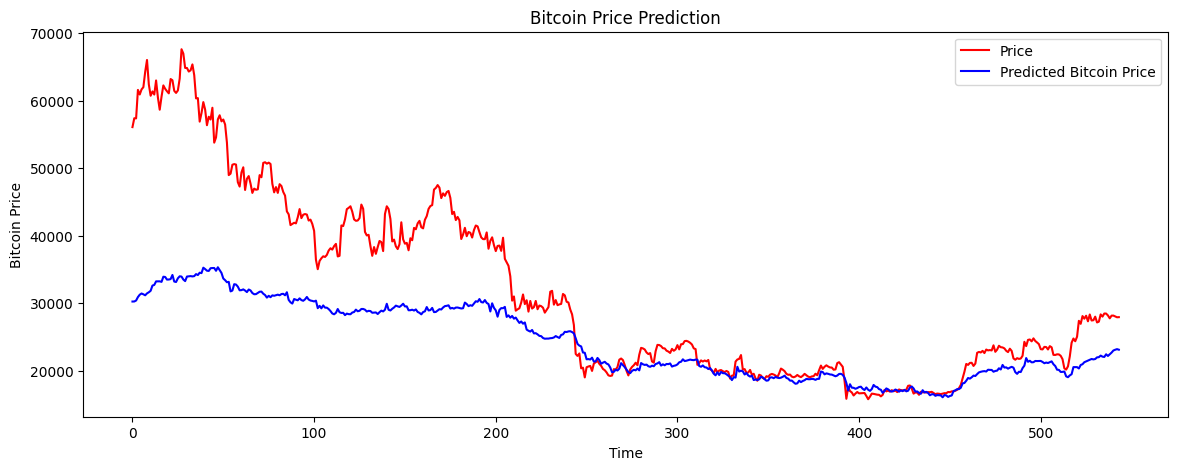

In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler

def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.01)

callback = LearningRateScheduler(scheduler)

# Read dataset
df = pd.read_csv('bitcoin-ta-on-chain-2015.csv')

# Convert timestamp to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Set timestamp as index
df = df.set_index('Timestamp')

# Prepare dataset
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train), len(test))

# Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(train)

# Create training data set
train_data = scaled_data

# Split data into X_train and y_train
X_train = []
y_train = []

for i in range(60, len(train_data)):
    X_train.append(train_data[i-60:i])
    y_train.append(train_data[i, 0])  # Here, 0 refers to the 'Price' column in the DataFrame

# Convert X_train and y_train to numpy arrays
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshape the data into 3-D array
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))

# Build LSTM model
model = Sequential()
model.add(Bidirectional(LSTM(units=480, return_sequences=False), input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.1))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=30, batch_size=39, validation_split=0.2, callbacks=[callback])

# Test data set
test_data = scaler.transform(test)

# Create the x_test and y_test data sets
X_test = []
test = test.iloc[60:]
y_test = test['Price'].values
test.reset_index(inplace=True)

for i in range(60, len(test_data)):
    X_test.append(test_data[i-60:i, :])

# Convert x_test to a numpy array 
X_test = np.array(X_test)

# Reshape the data into 3-D array
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))  # reshape X_test according to your X_train

# Check the model's prediction
predictions = model.predict(X_test)

# Assuming 'Price' is the first column in your df DataFrame
price_scaler = MinMaxScaler(feature_range=(0,1))
price_scaler.min_, price_scaler.scale_ = scaler.min_[0], scaler.scale_[0]

# Now you can inverse_transform your predictions
predictions = price_scaler.inverse_transform(predictions)

# Calculate mean squared error
from sklearn.metrics import mean_squared_error
print('Test Mean Squared Error:', mean_squared_error(y_test, predictions))

predictions = predictions.flatten()  # this will convert it into (num_samples, )
# Calculate mean absolute percentage error
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print('Test Mean Absolute Percentage Error:', mean_absolute_percentage_error(y_test, predictions))

# Import the necessary metrics from sklearn
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_squared_log_error

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print('Test Root Mean Squared Error:', rmse)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, predictions)
print('Test Mean Absolute Error:', mae)

# Calculate R-squared
r2 = r2_score(y_test, predictions)
print('Test R-squared:', r2)

# Calculate Adjusted R-squared
n = len(y_test)  # number of observations
p = X_test.shape[1]  # number of predictors
adjusted_r2 = 1 - (1-r2)*(n-1)/(n-p-1)
print('Test Adjusted R-squared:', adjusted_r2)

# Calculate Mean Squared Logarithmic Error (MSLE)
# Ensure all values are positive before using MSLE
if np.all(predictions > 0) and np.all(y_test > 0):
    msle = mean_squared_log_error(y_test, predictions)
    print('Test Mean Squared Logarithmic Error:', msle)
else:
    print('Can\'t calculate Mean Squared Logarithmic Error: some predictions or true values are negative or zero')


    
# Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(14,5))
plt.plot(y_test, color = 'red', label = 'Price')
plt.plot(predictions, color = 'blue', label = 'Predicted Bitcoin Price')
plt.title('Bitcoin Price Prediction')
plt.xlabel('Time')
plt.ylabel('Bitcoin Price')
plt.legend()
plt.show()

In [8]:
# Import necessary libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
import kerastuner as kt

# Define the function to build the model
def build_model(hp):
    model = Sequential()
    model.add(Bidirectional(LSTM(units=hp.Int('units', min_value=32, max_value=512, step=32),
                                  return_sequences=False),
                            input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='mean_squared_error')
    return model

# Load the dataset
df = pd.read_csv('bitcoin-ta-on-chain-2015.csv')

# Preprocessing steps
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df = df.set_index('Timestamp')

# Split the data
train_size = int(len(df) * 0.8)
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]

# Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(train)

# Create training data
X_train = []
y_train = []
for i in range(60, len(scaled_data)):
    X_train.append(scaled_data[i-60:i])
    y_train.append(scaled_data[i, 0])

# Convert to numpy arrays
X_train, y_train = np.array(X_train), np.array(y_train)
print(X_train.shape)


# Initialize the tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=115,
    directory='my_dir',
    project_name='helloworld')

# Perform hyperparameter search
tuner.search(X_train, y_train,
             epochs=30,
             validation_split=0.2)

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The optimal number of units in the LSTM layer is {best_hps.get('units')} and
the optimal learning rate for the optimizer is {best_hps.get('learning_rate')},
and the optimal dropout rate is {best_hps.get('dropout')}.
""")

Trial 81 Complete [00h 00m 24s]
val_loss: 0.01095067523419857

Best val_loss So Far: 0.0023701873142272234
Total elapsed time: 00h 28m 45s

Search: Running Trial #82

Value             |Best Value So Far |Hyperparameter
32                |288               |units
0.3               |0                 |dropout
0.001             |0.0001            |learning_rate

Epoch 1/30
15/59 [======>.......................] - ETA: 0s - loss: 0.0682

KeyboardInterrupt: ignored

In [17]:
# Import necessary libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
import kerastuner as kt

# Define the function to build the model
def build_model(hp):
    model = Sequential()
    model.add(Bidirectional(LSTM(units=hp.Int('units', min_value=32, max_value=512, step=32),
                                  return_sequences=False),
                            input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='mean_squared_error')
    return model

# Load the dataset
df = pd.read_csv('bitcoin-ta-on-chain-2015.csv')

# Preprocessing steps
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df = df.set_index('Timestamp')

# Split the data
train_size = int(len(df) * 0.8)
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]

# Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(train)

# Create training data
X_train = []
y_train = []
for i in range(60, len(scaled_data)):
    X_train.append(scaled_data[i-60:i])
    y_train.append(scaled_data[i, 0])

# Convert to numpy arrays
X_train, y_train = np.array(X_train), np.array(y_train)
print(X_train.shape)


# Initialize the tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=20,
    directory='my_dir',
    project_name='helloworld2')

# Perform hyperparameter search
tuner.search(X_train, y_train,
             epochs=30,
             validation_split=0.2)

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The optimal number of units in the LSTM layer is {best_hps.get('units')} and
and the optimal dropout rate is {best_hps.get('dropout')}.
""")

(2356, 60, 103)

The optimal number of units in the LSTM layer is 352 and 
and the optimal dropout rate is 0.1.



In [16]:
# Import necessary libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
import kerastuner as kt

# Define the function to build the model
def build_model(hp):
    model = Sequential()
    model.add(Bidirectional(LSTM(units=322, return_sequences=False),
                            input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='mean_squared_error')
    return model

# Load the dataset
df = pd.read_csv('bitcoin-ta-on-chain-2015.csv')

# Preprocessing steps
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df = df.set_index('Timestamp')

# Split the data
train_size = int(len(df) * 0.8)
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]

# Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(train)

# Create training data
X_train = []
y_train = []
for i in range(60, len(scaled_data)):
    X_train.append(scaled_data[i-60:i])
    y_train.append(scaled_data[i, 0])

# Convert to numpy arrays
X_train, y_train = np.array(X_train), np.array(y_train)
print(X_train.shape)


# Initialize the tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=20,
    directory='my_dir',
    project_name='helloworld4')

# Perform hyperparameter search
tuner.search(X_train, y_train,
             epochs=30,
             validation_split=0.2)

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The optimal dropout rate is {best_hps.get('dropout')}.
""")

Trial 5 Complete [00h 00m 25s]
val_loss: 0.010300541296601295

Best val_loss So Far: 0.006436730269342661
Total elapsed time: 00h 02m 03s

The optimal dropout rate is 0.4.



In [18]:
# Import necessary libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
import kerastuner as kt

# Define the function to build the model
def build_model(hp):
    model = Sequential()
    model.add(Bidirectional(LSTM(units=hp.Int('units', min_value=32, max_value=512, step=32),
                                  return_sequences=False),
                            input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.4))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='mean_squared_error')
    return model

# Load the dataset
df = pd.read_csv('bitcoin-ta-on-chain-2015.csv')

# Preprocessing steps
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df = df.set_index('Timestamp')

# Split the data
train_size = int(len(df) * 0.8)
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]

# Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(train)

# Create training data
X_train = []
y_train = []
for i in range(60, len(scaled_data)):
    X_train.append(scaled_data[i-60:i])
    y_train.append(scaled_data[i, 0])

# Convert to numpy arrays
X_train, y_train = np.array(X_train), np.array(y_train)
print(X_train.shape)


# Initialize the tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=20,
    directory='my_dir',
    project_name='helloworld5')

# Perform hyperparameter search
tuner.search(X_train, y_train,
             epochs=30,
             validation_split=0.2)

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The optimal number of units in the LSTM layer is {best_hps.get('units')} .
""")

Trial 15 Complete [00h 00m 24s]
val_loss: 0.011686782352626324

Best val_loss So Far: 0.00679867435246706
Total elapsed time: 00h 05m 40s

The optimal number of units in the LSTM layer is 128 .



## Try values 

2416 604
Epoch 1/30
49/49 [==============================] - 8s 91ms/step - loss: 0.1392 - val_loss: 0.0181 - lr: 1.0000e-04
Epoch 2/30
49/49 [==============================] - 4s 78ms/step - loss: 0.0647 - val_loss: 0.0529 - lr: 1.0000e-04
Epoch 3/30
49/49 [==============================] - 4s 76ms/step - loss: 0.0414 - val_loss: 0.0460 - lr: 1.0000e-04
Epoch 4/30
49/49 [==============================] - 4s 76ms/step - loss: 0.0306 - val_loss: 0.0499 - lr: 1.0000e-04
Epoch 5/30
49/49 [==============================] - 4s 78ms/step - loss: 0.0223 - val_loss: 0.0519 - lr: 1.0000e-04
Epoch 6/30
49/49 [==============================] - 4s 76ms/step - loss: 0.0189 - val_loss: 0.0488 - lr: 1.0000e-04
Epoch 7/30
49/49 [==============================] - 4s 77ms/step - loss: 0.0150 - val_loss: 0.0465 - lr: 1.0000e-04
Epoch 8/30
49/49 [==============================] - 4s 75ms/step - loss: 0.0129 - val_loss: 0.0477 - lr: 1.0000e-04
Epoch 9/30
49/49 [==============================] - 4s 77ms/ste

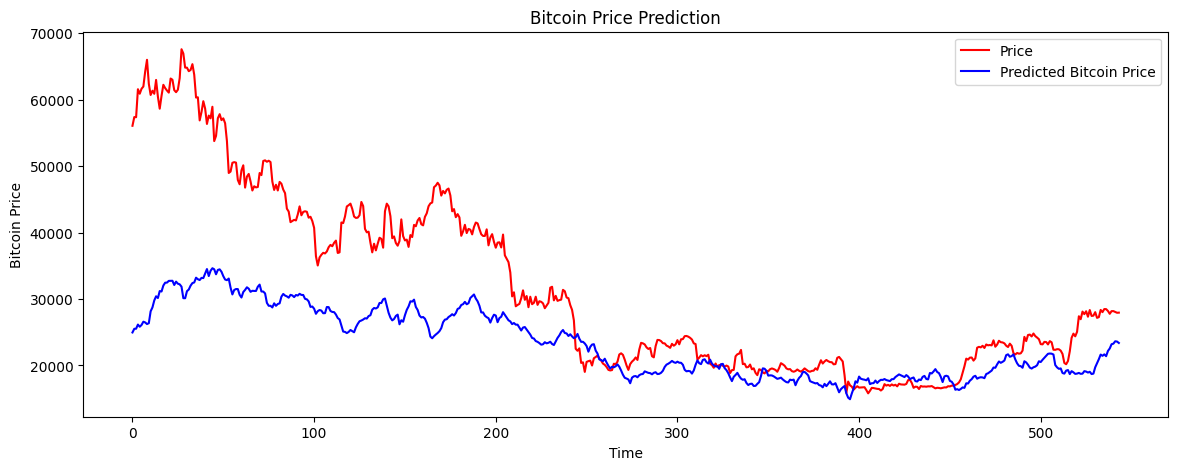

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler

def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.01)

callback = LearningRateScheduler(scheduler)

# Read dataset
df = pd.read_csv('bitcoin-ta-on-chain-2015.csv')

# Convert timestamp to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Set timestamp as index
df = df.set_index('Timestamp')

# Prepare dataset
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train), len(test))

# Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(train)

# Create training data set
train_data = scaled_data

# Split data into X_train and y_train
X_train = []
y_train = []

for i in range(60, len(train_data)):
    X_train.append(train_data[i-60:i])
    y_train.append(train_data[i, 0])  # Here, 0 refers to the 'Price' column in the DataFrame

# Convert X_train and y_train to numpy arrays
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshape the data into 3-D array
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))

# Build LSTM model
model = Sequential()
model.add(Bidirectional(LSTM(units=128, return_sequences=False), input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.4))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=30, batch_size=39, validation_split=0.2, callbacks=[callback])

# Test data set
test_data = scaler.transform(test)

# Create the x_test and y_test data sets
X_test = []
test = test.iloc[60:]
y_test = test['Price'].values
test.reset_index(inplace=True)

for i in range(60, len(test_data)):
    X_test.append(test_data[i-60:i, :])

# Convert x_test to a numpy array 
X_test = np.array(X_test)

# Reshape the data into 3-D array
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))  # reshape X_test according to your X_train

# Check the model's prediction
predictions = model.predict(X_test)

# Assuming 'Price' is the first column in your df DataFrame
price_scaler = MinMaxScaler(feature_range=(0,1))
price_scaler.min_, price_scaler.scale_ = scaler.min_[0], scaler.scale_[0]

# Now you can inverse_transform your predictions
predictions = price_scaler.inverse_transform(predictions)

# Calculate mean squared error
from sklearn.metrics import mean_squared_error
print('Test Mean Squared Error:', mean_squared_error(y_test, predictions))

predictions = predictions.flatten()  # this will convert it into (num_samples, )
# Calculate mean absolute percentage error
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print('Test Mean Absolute Percentage Error:', mean_absolute_percentage_error(y_test, predictions))

# Import the necessary metrics from sklearn
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_squared_log_error

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print('Test Root Mean Squared Error:', rmse)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, predictions)
print('Test Mean Absolute Error:', mae)

# Calculate R-squared
r2 = r2_score(y_test, predictions)
print('Test R-squared:', r2)

# Calculate Adjusted R-squared
n = len(y_test)  # number of observations
p = X_test.shape[1]  # number of predictors
adjusted_r2 = 1 - (1-r2)*(n-1)/(n-p-1)
print('Test Adjusted R-squared:', adjusted_r2)

# Calculate Mean Squared Logarithmic Error (MSLE)
# Ensure all values are positive before using MSLE
if np.all(predictions > 0) and np.all(y_test > 0):
    msle = mean_squared_log_error(y_test, predictions)
    print('Test Mean Squared Logarithmic Error:', msle)
else:
    print('Can\'t calculate Mean Squared Logarithmic Error: some predictions or true values are negative or zero')


    
# Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(14,5))
plt.plot(y_test, color = 'red', label = 'Price')
plt.plot(predictions, color = 'blue', label = 'Predicted Bitcoin Price')
plt.title('Bitcoin Price Prediction')
plt.xlabel('Time')
plt.ylabel('Bitcoin Price')
plt.legend()
plt.show()